# Emotion Recognition with simple CNN

### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

2025-12-24 15:12:43.571089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


### Dataset loading

In [3]:
# Load dataset
from typing import Any
from keras.preprocessing import image_dataset_from_directory

cwd: str = os.getcwd()

train_dir: str = os.path.join(cwd, "../data/train")
test_dir: str = os.path.join(cwd, "../data/test")

batch_size: int = 128
img_size: tuple = (48, 48)
seed: int = 42

class_names: list[str] = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Load training and validation datasets
train_dataset: list[Any] | Any = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
)

validation_dataset: list[Any] | Any = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
)

# Load test dataset
test_dataset: list[Any] | Any = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1766581989.687750    1121 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:06:00.0, compute capability: 8.9


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Show one example image for each class from the training dataset

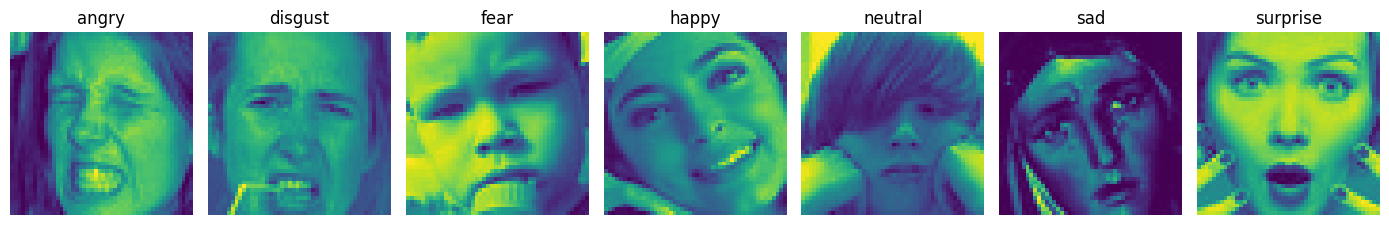

In [5]:
def show_one_example_per_class(dataset, class_names):
    num_classes: int = len(class_names)
    sample_images: list[Any] = [None] * num_classes

    # Collect one image per class
    for img, label in dataset.unbatch():
        # Handle integer vs categorical (one-hot) labels
        if label.shape.rank == 0:  # scalar int label
            class_idx = int(label.numpy())
        else:  # one-hot / categorical label
            class_idx = int(tf.argmax(label).numpy())

        if 0 <= class_idx < num_classes and sample_images[class_idx] is None:
            sample_images[class_idx] = img.numpy()

        if all(im is not None for im in sample_images):
            break

    # Plot
    plt.figure(figsize=(14, 3))
    for i, (img, cname) in enumerate(zip(sample_images, class_names)):
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(cname)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Call the function
show_one_example_per_class(train_dataset, class_names)


In [4]:
def plot_class_distribution(dataset_dir, subset_name):
    """Plot the class distribution of the dataset"""
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images

    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name)
    plt.show()

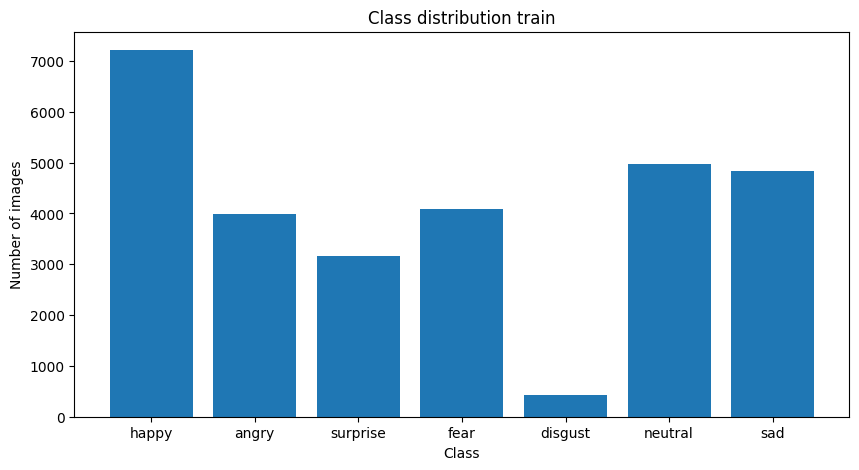

In [5]:
plot_class_distribution(train_dir, "train")

In [35]:
# Print class distribution
class_count = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_count[class_name] = num_images

print("Class Distribution:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Class Distribution:
happy: 7215
angry: 3995
surprise: 3171
fear: 4097
disgust: 436
neutral: 4965
sad: 4830


### Helper Classes and Functions

In [6]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create the data augmentation pipeline"""
        return keras.Sequential(
            [
                keras.layers.RandomFlip("horizontal"),
                keras.layers.RandomRotation(0.1),
                keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            ]
        )

    def preprocess_image(self, image, to_gray):
        """Convert image to grayscale float32 and normalize"""
        if to_gray:
            image = tf.image.rgb_to_grayscale(image)

        # Normalize to [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)

        # Boost contrast
        image = tf.image.adjust_contrast(image, 2.0)
        return image

    def augment_and_preprocess(self, image, augment, to_gray):
        """Apply data augmentation and preprocess the image"""
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image, to_gray)

    def prepare_dataset(self, dataset, augment=False, to_gray=False):
        """Prepare a single dataset split for training"""
        dataset = dataset.map(
            lambda x, y: (self.augment_and_preprocess(x, augment, to_gray), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [7]:
def plot_history(history) -> None:
    """Function to plot the training and validation history"""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()


In [8]:
def metrics(model, class_names, test_ds):
    """Function to calculate the metrics of the model"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")

    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    # Get the true labels
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    # Check if labels are one-hot or integer before applying argmax
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report

    print(classification_report(y_true, y_pred))

    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [15]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Dict, Any, Union, List, Optional


def generate_class_weights(
    class_series: Union[List[Any], np.ndarray, tf.Tensor],
    multi_class: bool = True,
    one_hot_encoded: Optional[bool] = None,
    num_classes: Optional[int] = None,
) -> Dict[int, float]:
    """
    Generates class weights.

    - multi_class=True:
        Supports sparse int labels (N,) and categorical/one-hot labels (N, C).
        Returns dict usable with Keras `class_weight`.

    - multi_class=False (multi-label):
        Supports:
          * list-of-labels per sample: [[0, 2], [1], ...]
          * one-hot/multi-hot matrix: (N, C)
        Returns per-class weights (NOT directly compatible with `class_weight`;
        you must convert to `sample_weight`).
    """
    # Convert input to numpy when possible
    if isinstance(class_series, tf.Tensor):
        y_raw = class_series.numpy()
    else:
        y_raw = np.asarray(class_series, dtype=object)

    # -----------------------
    # MULTI-CLASS (single label)
    # -----------------------
    if multi_class:
        # Auto-detect one-hot if not provided
        if one_hot_encoded is None:
            one_hot_encoded = hasattr(y_raw, "ndim") and y_raw.ndim > 1

        if one_hot_encoded:
            y = np.asarray(y_raw)
            if y.ndim < 2:
                raise ValueError("one_hot_encoded=True but labels are not 2D+ (N, C).")
            if num_classes is None:
                num_classes = int(y.shape[-1])
            y_idx = np.argmax(y, axis=-1).astype(np.int64)
        else:
            y_idx = np.asarray(y_raw, dtype=np.int64).reshape(-1)
            if y_idx.size == 0:
                raise ValueError("Empty labels.")
            if num_classes is None:
                num_classes = int(y_idx.max()) + 1

        # Use all classes 0..num_classes-1 (even if some are missing)
        classes = np.arange(num_classes, dtype=np.int64)
        weights = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y_idx,
        )
        return {int(i): float(w) for i, w in zip(classes, weights)}

    # -----------------------
    # MULTI-LABEL
    # -----------------------
    # Auto-detect one-hot/multi-hot matrix if not provided
    if one_hot_encoded is None:
        one_hot_encoded = hasattr(y_raw, "ndim") and y_raw.ndim > 1

    if one_hot_encoded:
        y = np.asarray(y_raw, dtype=np.int64)
        if y.ndim != 2:
            raise ValueError(
                "For multi-label one-hot/multi-hot, expected shape (N, C)."
            )
        if num_classes is None:
            num_classes = int(y.shape[1])
    else:
        # Expect list-of-labels per sample
        mlb = MultiLabelBinarizer(
            classes=list(range(num_classes)) if num_classes is not None else None
        )
        y = mlb.fit_transform(class_series)
        if num_classes is None:
            num_classes = int(y.shape[1])

    n_samples = float(y.shape[0])
    n_classes = float(num_classes)

    class_counts = y.sum(axis=0).astype(np.float64)

    # Balanced weighting: n_samples / (n_classes * count_c)
    weights = np.ones(int(num_classes), dtype=np.float64)
    nonzero = class_counts > 0
    weights[nonzero] = n_samples / (n_classes * class_counts[nonzero])

    return {int(i): float(weights[i]) for i in range(int(num_classes))}

In [10]:
def plot_train_history(history) -> None:
    # Summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

    # Summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()


### Model Creation

In [11]:
from keras import layers

@keras.saving.register_keras_serializable()
class RealTimeCNN(keras.Model):
    def __init__(self, num_classes=7, **kwargs):
        super().__init__(**kwargs)

        # Block 1
        self.conv1_1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv1_2 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = layers.Dropout(0.25)

        # Block 2
        self.conv2_1 = layers.Conv2D(128, (5, 5), padding="same", activation="relu")
        self.bn3 = layers.BatchNormalization()
        self.conv2_2 = layers.Conv2D(128, (5, 5), padding="same", activation="relu")
        self.bn4 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop2 = layers.Dropout(0.25)

        # Block 3
        self.conv3_1 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.bn5 = layers.BatchNormalization()
        self.conv3_2 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.bn6 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop3 = layers.Dropout(0.25)

        # Block 4
        self.conv4_1 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")
        self.bn7 = layers.BatchNormalization()
        self.conv4_2 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")
        self.bn8 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop4 = layers.Dropout(0.25)

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(1024, activation="relu")
        self.bn9 = layers.BatchNormalization()
        self.drop5 = layers.Dropout(0.5)

        self.dense2 = layers.Dense(512, activation="relu")
        self.bn10 = layers.BatchNormalization()
        self.drop6 = layers.Dropout(0.5)

        self.out = layers.Dense(num_classes, activation="softmax")

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs, training=False):
        x = self.conv1_1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv1_2(x)
        x = self.bn2(x, training=training)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.conv2_1(x)
        x = self.bn3(x, training=training)
        x = self.conv2_2(x)
        x = self.bn4(x, training=training)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        x = self.conv3_1(x)
        x = self.bn5(x, training=training)
        x = self.conv3_2(x)
        x = self.bn6(x, training=training)
        x = self.pool3(x)
        x = self.drop3(x, training=training)

        x = self.conv4_1(x)
        x = self.bn7(x, training=training)
        x = self.conv4_2(x)
        x = self.bn8(x, training=training)
        x = self.pool4(x)
        x = self.drop4(x, training=training)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn9(x, training=training)
        x = self.drop5(x, training=training)

        x = self.dense2(x)
        x = self.bn10(x, training=training)
        x = self.drop6(x, training=training)

        return self.out(x)

    def get_config(self):
        return super().get_config()


model = RealTimeCNN(num_classes=7)
model.build((None, 48, 48, 1))
model.summary()
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

Model: "real_time_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-5, verbose=1,
    ),
    ModelCheckpoint(
        filepath=f"{cwd}/../model_checkpoints/realtime-cnn.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [13]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)
validation_ds = dataset_preparer.prepare_dataset(validation_dataset)
test_ds = dataset_preparer.prepare_dataset(test_dataset)

In [16]:
y_train = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
class_weights = generate_class_weights(
    y_train,
    multi_class=True,
)
print("Class Weights:", class_weights)

Class Weights: {0: 1.0196217703986505, 1: 9.03896103896104, 2: 0.998825831702544, 3: 0.5644491410877098, 4: 0.8275265717888669, 5: 0.8558014755197854, 6: 1.3177280550774526}


2025-12-24 15:26:50.110424: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
validation_steps = int(tf.data.experimental.cardinality(validation_ds).numpy())

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=validation_ds,
    callbacks=my_callbacks,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/100


2025-12-24 15:27:05.712523: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f704c003960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-24 15:27:05.712558: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-24 15:27:05.904120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-24 15:27:09.424797: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-24 15:27:11.326814: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4519', 8956 bytes spill stores, 10196 bytes spill loads

I0000 00:00:1766582844.119877    9449 device_compiler.h:196] Compiled cluster using XLA!  This line is log

179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1500 - loss: 2.8333

2025-12-24 15:27:35.394521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5004', 4 bytes spill stores, 4 bytes spill loads

2025-12-24 15:27:35.490312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4519', 12 bytes spill stores, 12 bytes spill loads

2025-12-24 15:27:35.505002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5279', 4 bytes spill stores, 4 bytes spill loads

2025-12-24 15:27:35.579979: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5203', 4 bytes spill stores, 4 bytes spill loads

2025-12-24 15:27:35.601181: I external/local_x

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1500 - loss: 2.8319

2025-12-24 15:27:51.498701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_348', 8 bytes spill stores, 8 bytes spill loads

2025-12-24 15:27:51.500390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_359', 8 bytes spill stores, 8 bytes spill loads

2025-12-24 15:27:51.702645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_348', 60 bytes spill stores, 60 bytes spill loads

2025-12-24 15:27:51.717384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_359', 60 bytes spill stores, 60 bytes spill loads

2025-12-24 15:27:51.952797: I external/local_xla

180/180 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.1575 - loss: 2.5807 - val_accuracy: 0.1716 - val_loss: 3.9683 - learning_rate: 0.0010
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.1782 - loss: 2.1853 - val_accuracy: 0.1615 - val_loss: 2.3038 - learning_rate: 0.0010
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.1862 - loss: 2.0404 - val_accuracy: 0.1742 - val_loss: 2.4252 - learning_rate: 0.0010
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.2013 - loss: 1.9765 - val_accuracy: 0.1841 - val_loss: 1.9458 - learning_rate: 0.0010
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.2225 - loss: 1.8970 - val_accuracy: 0.2289 - val_loss: 1.9221 - learning_rate: 0.0010
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.2610 - loss: 1.8452 - val_accuracy: 0.2315 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.2756 - loss:

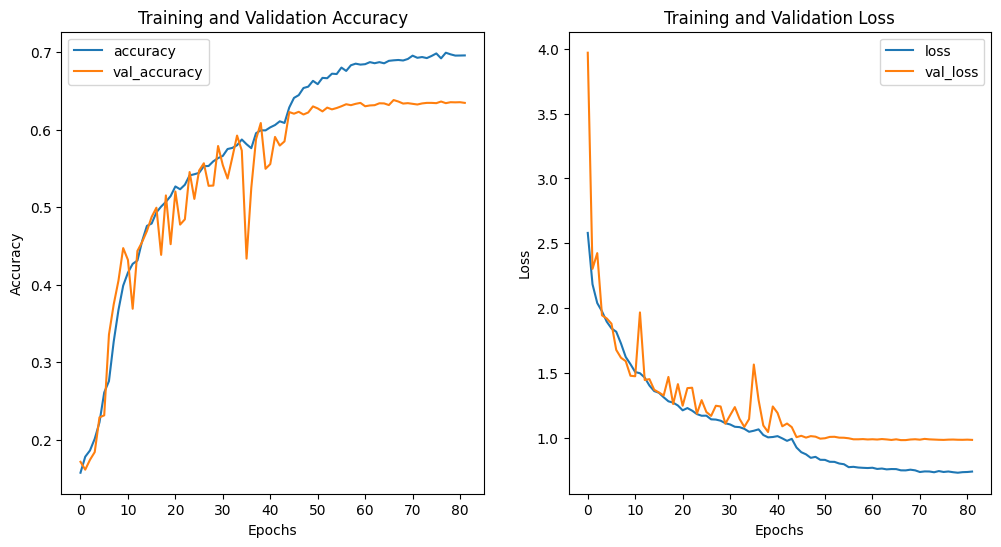

In [18]:
plot_history(history=history)

In [ ]:
best_model = RealTimeCNN(num_classes=7)

best_model.build((None, 48, 48, 1))

best_model.load_weights(f"{cwd}/../model_checkpoints/realtime-cnn.keras")

best_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1427 - loss: 4.3328
Test Loss: 0.14265812933444977
Test Accuracy: 4.332751750946045


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1427 - loss: 4.3328
Loss: 4.332751750946045
Accuracy: 0.14265812933444977


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.14      1.00      0.25      1024
           3       0.00      0.00      0.00      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.14      7178
   macro avg       0.16      0.14      0.04      7178
weighted avg       0.15      0.14      0.04      7178



/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

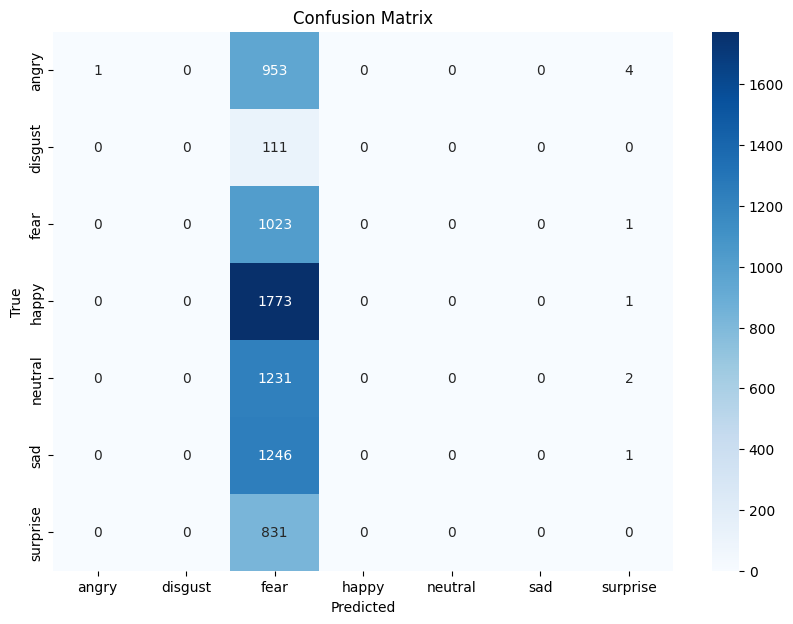

In [20]:
metrics(best_model, class_names, test_ds)